# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

Book verison of this notebook - https://www.learnpytorch.io/02_pytorch_classification/

### What we're going to cover
* Architecture of a neural network classification model.
* Input shapes and output shapes of of a classification model (feature and labels)
* Creating custom data to view, fit on and predict on.
* Steps in modelling.
* Creating a model, setting a loss function and optimiser, creating a training loop, evaluating model.
* Saving and loding models.
* Harnessing the power of non-linearity.
* different classification evaluation methods.

In [1]:
## 1. Make classification data and get it ready
import sklearn
from sklearn.datasets import make_circles

# Make 100 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 samples of X: \n{X[:5]} \n")
print(f"First 5 samples of y: \n{y[:5]} \n")

First 5 samples of X: 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] 

First 5 samples of y: 
[1 1 1 1 0] 



In [4]:
# Make DataFrame of circle data
import pandas as pd
circle = pd.DataFrame({"X1": X[:,0],
                      "X2": X[:,1],
                      "label": y})
circle.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


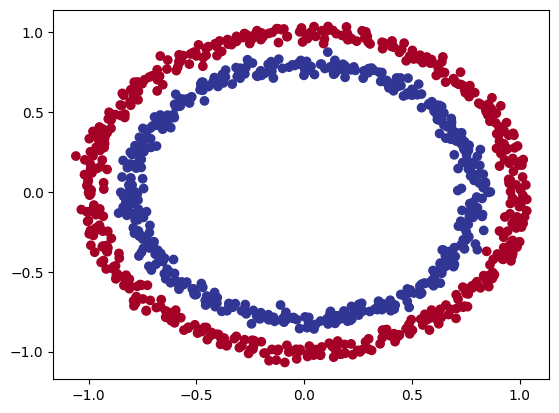

In [5]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
           y=X[:,1],
           c=y,
           cmap=plt.cm.RdYlBu);

**Note:** The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.**bold text**

### 1.1 Check input and output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
#  View the first exampe of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [8]:
import torch
torch.__version__

'2.4.0+cu121'

In [9]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [10]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [12]:
# Split data into trainng and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing nn.Module)
3. Define a loss function and optimizer.
4. Create a training and test loop.

In [13]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic mode
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've setup device agnostic code, let's create a model that:
1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shape of our data.
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model.
4. Instatiate an instance of our model class and send it to the target `device`

In [14]:
# 1. Construct a model that subclasses nn.Module
class CirlceModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, # takes in 2 features and upscale to 5 features
                             out_features=5)
    self.layer_2 = nn.Linear(in_features=5, # takes in 5 features from previous layer and ouputs a single feature (same shape as y)
                             out_features=1)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output


  # 4. Instantiate an instance of our model class and send it to the target device
model_0 = CirlceModelV0().to(device)
model_0


CirlceModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [16]:
#  Let's replicate the model above using nn.Squential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6809, -0.1666],
                      [-0.5008, -0.6496],
                      [ 0.2938,  0.2615],
                      [ 0.4609, -0.6104],
                      [-0.1320, -0.3255]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6862, -0.0553, -0.2797,  0.6146, -0.0131], device='cuda:0')),
             ('1.weight',
              tensor([[-0.1644,  0.3153,  0.0643, -0.0233, -0.3632]], device='cuda:0')),
             ('1.bias', tensor([0.2550], device='cuda:0'))])

In [18]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: {untrained_preds[:10]}")
print(f"First 10 test samples: {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: tensor([[0.3839],
        [0.2926],
        [0.4820],
        [0.3566],
        [0.2577],
        [0.2037],
        [0.1244],
        [0.1030],
        [0.4913],
        [0.2840]], device='cuda:0')
First 10 test samples: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again...this is problem specific.

For example for regression you might want MAE or MSE (mean absolute error or mean squared error).

For classification you might want binary cross entorpy or categorical cross entropy

As a reminder, the loss function measures how *wrong* your models predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* For the lose function we're going to use `torch.nn.BCEWithLogitsLoss()` , for more on what binary cross entropy (BCE) is, check out this article - https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

In [19]:
# Setup the Loss Function
#loss_fn = nn.BCEWithLogitsLoss() # BCELoss = requires inputs to have gone through the sigmoid activation function priror to input to BCELoss

loss_fn =  nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in

# Setup the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [20]:
# calculate accuracy - out of 100 example , what percentage does our model get right?

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

## 3. Train Model

To train our model we're going to need to build a training loop:
1. Forward pass
2. calculate the loss
3. optimizer zero grad
4. loss backward (backpropagation)
5. Optimizer step (gradient descent)

## 3.1 Going from raw logits -> prediction probabilites  -> prediction labels

our model outputs are going to be raw **logits**

we can convert these **logits** into prediction probabilites by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilites to **prediction labels** by either rounding them or taking the argmax(

In [21]:
# view the first 5 outputs of the forward pass on the test data
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.3839],
        [0.2926],
        [0.4820],
        [0.3566],
        [0.2577]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5 , `y=1` (class 0)
* `y_pred_probs` < 0.5 , `y=0` (class 1)

In [22]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilites
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5948],
        [0.5726],
        [0.6182],
        [0.5882],
        [0.5641]], device='cuda:0')

In [23]:
# find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

#  check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

#  get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

## 3.2 Building training and Testing loop

In [24]:
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate the loss
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)

  # loss = loss_fn(torch.sigmoid(y_logits), y_train) # nn.BCELoss expects prediction probabilities as input


  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out what's happenin
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70915, Acc: 50.00% | Test Loss: 0.70398, Test Acc: 50.00%
Epoch: 10 | Loss: 0.69906, Acc: 50.00% | Test Loss: 0.69637, Test Acc: 51.00%
Epoch: 20 | Loss: 0.69561, Acc: 55.00% | Test Loss: 0.69412, Test Acc: 54.50%
Epoch: 30 | Loss: 0.69435, Acc: 51.00% | Test Loss: 0.69354, Test Acc: 55.50%
Epoch: 40 | Loss: 0.69383, Acc: 49.88% | Test Loss: 0.69346, Test Acc: 56.00%
Epoch: 50 | Loss: 0.69357, Acc: 49.62% | Test Loss: 0.69351, Test Acc: 55.00%
Epoch: 60 | Loss: 0.69342, Acc: 49.38% | Test Loss: 0.69360, Test Acc: 54.50%
Epoch: 70 | Loss: 0.69331, Acc: 49.38% | Test Loss: 0.69369, Test Acc: 52.50%
Epoch: 80 | Loss: 0.69324, Acc: 49.75% | Test Loss: 0.69378, Test Acc: 51.50%
Epoch: 90 | Loss: 0.69318, Acc: 49.62% | Test Loss: 0.69386, Test Acc: 50.50%


## 4.Make prections and evaluate the module

From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual

To do so, we're going to import a function called `plot_decision_boundry()` - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [25]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch rep (if it's not already download)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_decision_boundary, plot_predictions


In [26]:
# import numpy as np
# plt.style.use('fivethirtyeight')
# def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
#     """Plots decision boundaries of model predicting on X in comparison to y.

#     Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
#     """
#     # Put everything to CPU (works better with NumPy + Matplotlib)
#     model.to("cpu")
#     X, y = X.to("cpu"), y.to("cpu")

#     # Setup prediction boundaries and grid
#     x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
#     y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
#     xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

#     # Make features
#     X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

#     # Make predictions
#     model.eval()
#     with torch.inference_mode():
#         y_logits = model(X_to_pred_on)

#     # Test for multi-class or binary and adjust logits to prediction labels
#     if len(torch.unique(y)) > 2:
#         y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
#     else:
#         y_pred = torch.round(torch.sigmoid(y_logits))  # binary

#     # Reshape preds and plot
#     y_pred = y_pred.reshape(xx.shape).detach().numpy()
#     plt.contourf(xx, yy, y_pred,cmap='RdYlGn', alpha=0.7)
#     plt.scatter(X[:, 0], X[:, 1], c=y, s=40,cmap = 'RdYlGn')
#     plt.xlim(xx.min(), xx.max())
#     plt.ylim(yy.min(), yy.max())

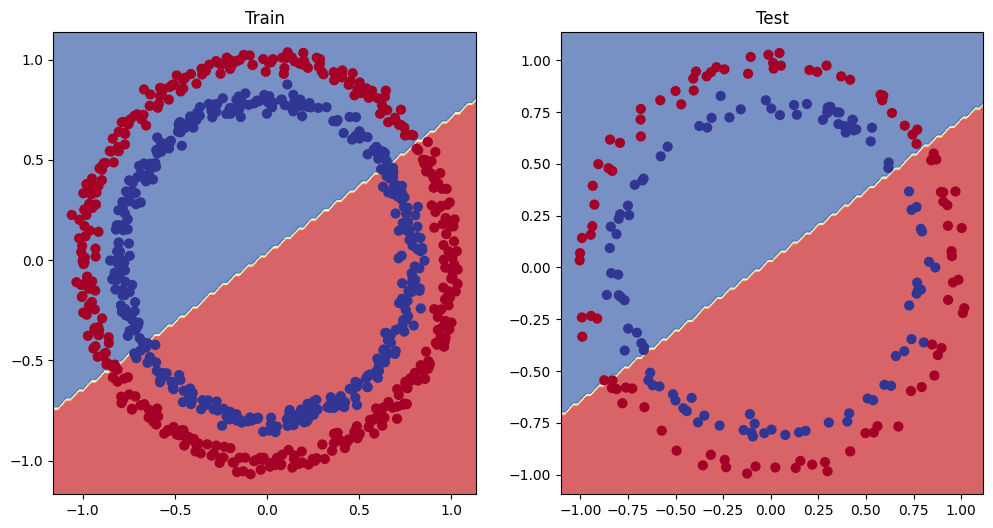

In [27]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)
* Add more layers -  giver the model more chance to learn about pattern in the data.
* Add more hidden units - go from 5 hidden units to 10 hidden units.
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning and data scientists) can change, they are referred as **Hyperparameter**

Let's try and improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers 2 -> 3
* Increase the number of epochs 100 -> 1000


In [28]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6739, -0.1685],
                      [-0.4666, -0.6428],
                      [ 0.3075,  0.2639],
                      [ 0.4528, -0.6118],
                      [-0.1774, -0.3342]])),
             ('0.bias', tensor([-0.6724, -0.0954, -0.2921,  0.6220,  0.0363])),
             ('1.weight',
              tensor([[ 0.0034,  0.2521,  0.1445, -0.0650, -0.3908]])),
             ('1.bias', tensor([0.1216]))])

In [29]:
class CirlceModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, # takes in 2 features and upscale to 5 features
                             out_features=10)
    self.layer_2 = nn.Linear(in_features=10,
                             out_features=10)
    self.layer_3 = nn.Linear(in_features=10,
                             out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(x)
    # z = self.layer_3(x)
    # return z
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CirlceModelV1().to(device)
model_1

CirlceModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [30]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [31]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()

  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities ->pred labels

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():

    # 1. forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred =test_pred)

    # Print out whats happenin
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70131, Acc: 49.50% | Test Loss: 0.70819, Test Acc: 49.00%
Epoch: 100 | Loss: 0.69342, Acc: 50.38% | Test Loss: 0.69645, Test Acc: 47.00%
Epoch: 200 | Loss: 0.69301, Acc: 50.62% | Test Loss: 0.69504, Test Acc: 47.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.25% | Test Loss: 0.69476, Test Acc: 46.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.38% | Test Loss: 0.69469, Test Acc: 45.50%
Epoch: 500 | Loss: 0.69298, Acc: 51.38% | Test Loss: 0.69468, Test Acc: 45.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.12% | Test Loss: 0.69468, Test Acc: 45.50%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test Acc: 46.00%


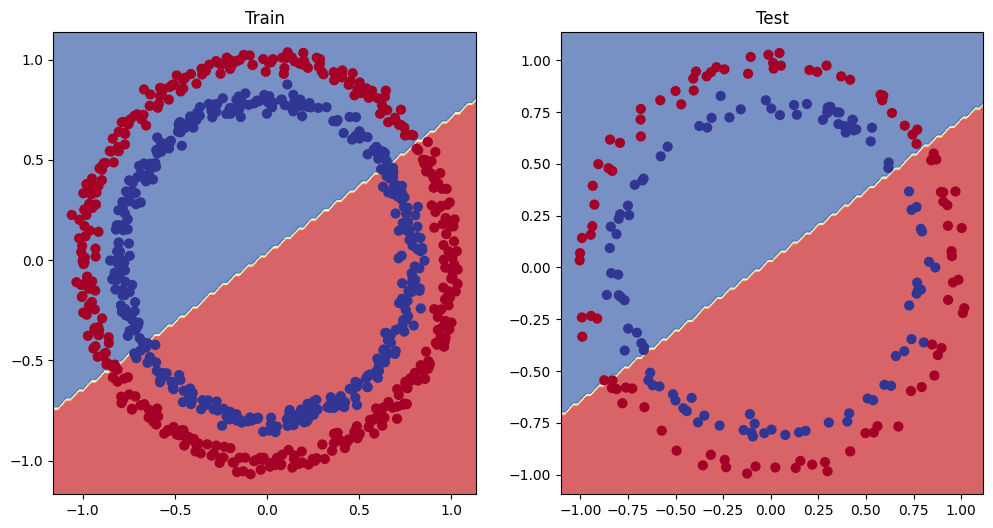

In [32]:
# plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### 5.1 Prepareing data to see if our model can fit a straight line

One way to trouble  to a larger problem is to test out a smaller problem

In [33]:
#  Crreate some data (same as notebook 01)
weight = 0.7
bias = 0.3
start =0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula (without option)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [34]:
# Crete train and test split
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# check the lengths of each
len(X_train_regression), len(y_train_regression), len(X_test_regression), len(y_test_regression)

(80, 80, 20, 20)

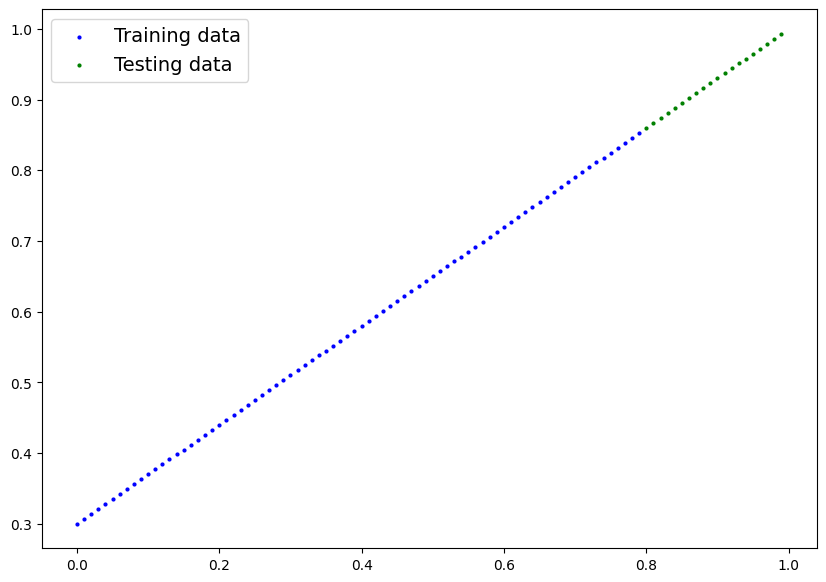

In [35]:
plot_predictions(train_data = X_train_regression,
                 train_labels = y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression);

In [36]:
model_1

CirlceModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

### 5.2 Adjusting `model_1` to fit a straight line

In [37]:
# Same architecture an model_1 (using using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1,
              out_features=10),
    nn.Linear(in_features = 10,
              out_features = 10),
    nn.Linear(in_features = 10,
              out_features = 1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [38]:
# loss and optimizer
loss_fn = nn.L1Loss()
optimizer =  torch.optim.SGD(params = model_2.parameters(),
                             lr = 0.1)

In [39]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_prediction = model_2(X_test_regression)
    test_loss = loss_fn(test_prediction, y_test_regression)

    # Print out what's happein'
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test Loss: 0.54143
Epoch: 100 | Loss: 0.09309 | Test Loss: 0.02901
Epoch: 200 | Loss: 0.07376 | Test Loss: 0.02850
Epoch: 300 | Loss: 0.06745 | Test Loss: 0.00615
Epoch: 400 | Loss: 0.06107 | Test Loss: 0.02004
Epoch: 500 | Loss: 0.05698 | Test Loss: 0.01061
Epoch: 600 | Loss: 0.04857 | Test Loss: 0.01326
Epoch: 700 | Loss: 0.06109 | Test Loss: 0.02127
Epoch: 800 | Loss: 0.05599 | Test Loss: 0.01426
Epoch: 900 | Loss: 0.05571 | Test Loss: 0.00603


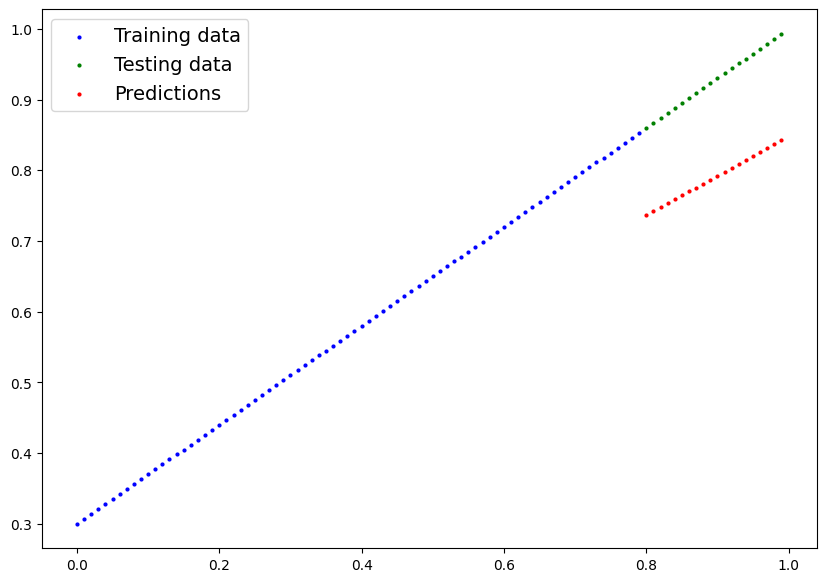

In [40]:
# Turn on evaluation mode
model_2.eval()

# Make prediction (inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# plot data and predictions
plot_predictions(train_data = X_train_regression.cpu(),
                 train_labels = y_train_regression.cpu(),
                 test_data = X_test_regression.cpu(),
                 test_labels = y_test_regression.cpu(),
                 predictions = y_preds.cpu());

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of a stright and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

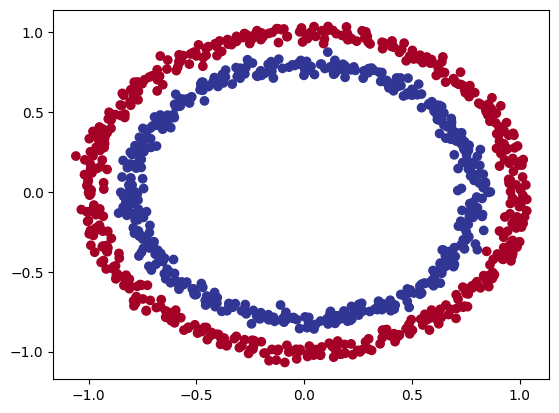

In [41]:
# Make and plot data
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state=42)

plt.scatter(X[:,0], X[:,1], c= y, cmap = plt.cm.RdYlBu);

In [42]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [43]:
X_train[:5], X_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]))

### 6.2 Building a model with non linearity
* Linear = Straight linear
* Non-linear = non-straight lines

Artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data.

In [44]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # <- non-linearity

  def forward(self, x):
      # Where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [45]:
# setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

### 6.3 Training a model with non-linearity.

In [46]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# lopp
epochs = 1000

for epoch in range(epochs):
  # Training
  model_3.train()

  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train) #BCEWithLogitLoss (takes in logits as first input)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backward
  loss.backward()

  # 5. optimizer step
  optimizer.step()

  # Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out what's happenin'
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Acc: 50.00% | Test Loss: 0.69319, Test Acc: 50.00%
Epoch: 100 | Loss: 0.69115, Acc: 52.88% | Test Loss: 0.69102, Test Acc: 52.50%
Epoch: 200 | Loss: 0.68977, Acc: 53.37% | Test Loss: 0.68940, Test Acc: 55.00%
Epoch: 300 | Loss: 0.68795, Acc: 53.00% | Test Loss: 0.68723, Test Acc: 56.00%
Epoch: 400 | Loss: 0.68517, Acc: 52.75% | Test Loss: 0.68411, Test Acc: 56.50%
Epoch: 500 | Loss: 0.68102, Acc: 52.75% | Test Loss: 0.67941, Test Acc: 56.50%
Epoch: 600 | Loss: 0.67515, Acc: 54.50% | Test Loss: 0.67285, Test Acc: 56.00%
Epoch: 700 | Loss: 0.66659, Acc: 58.38% | Test Loss: 0.66322, Test Acc: 59.00%
Epoch: 800 | Loss: 0.65160, Acc: 64.00% | Test Loss: 0.64757, Test Acc: 67.50%
Epoch: 900 | Loss: 0.62362, Acc: 74.00% | Test Loss: 0.62145, Test Acc: 79.00%


### 6.4 Evaluating a model trained with non-linear activation function

In [47]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_logits = model_3(X_test).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

In [48]:
y_pred[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

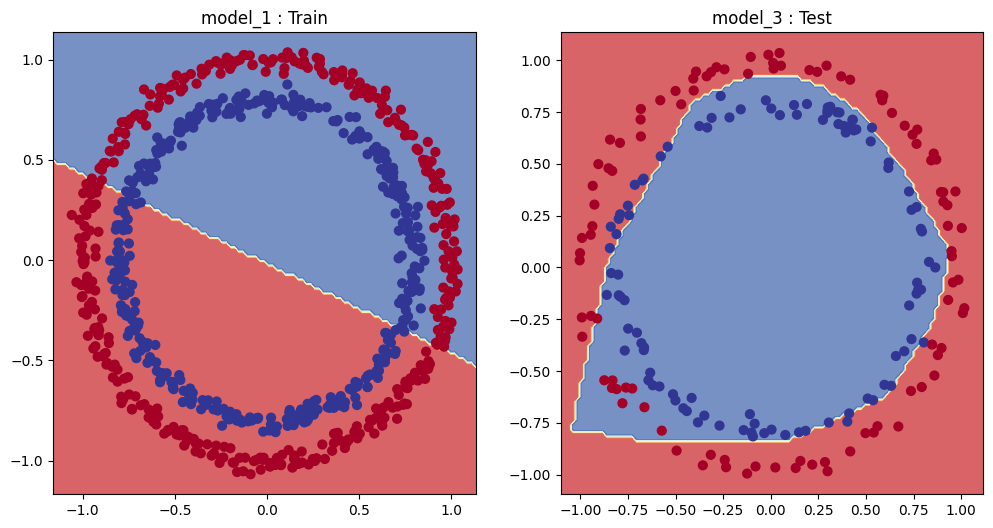

In [49]:
# plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("model_1 : Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("model_3 : Test")
plot_decision_boundary(model_3, X_test, y_test);

## 7. Replicating non-linear activation functions

Neural network, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear & non-linear functions.

In [50]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [51]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

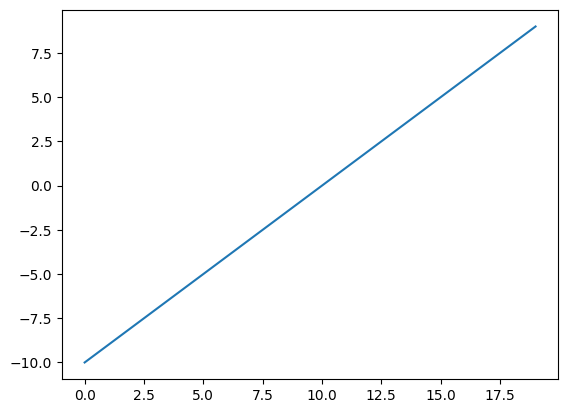

In [52]:
# Visualize the tensor
plt.plot(A);

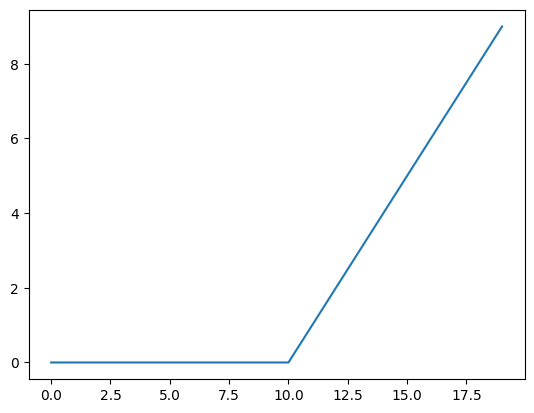

In [53]:
plt.plot(torch.relu(A));

In [54]:
def relu(x : torch.Tensor) -> torch.Tensor:
  return torch.max(torch.tensor(0), x) # inputs must be tensor

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

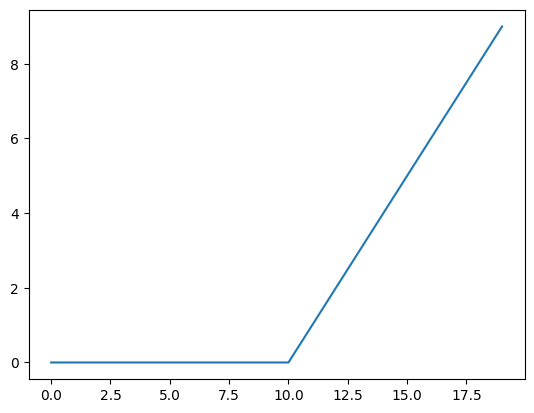

In [55]:
# plot relu function
plt.plot(relu(A));

In [56]:
# now let's do the same for sigmoid
def sigmoid(x : torch.Tensor) -> torch.Tensor:
  return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

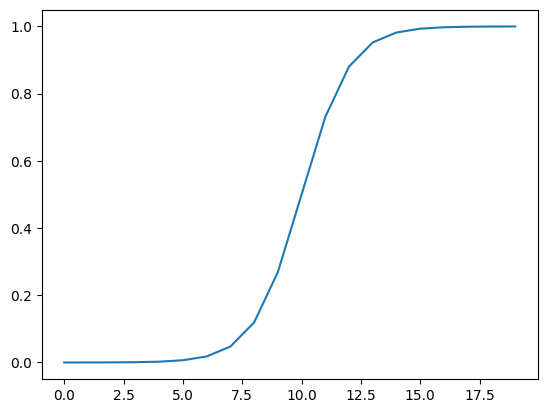

In [57]:
plt.plot(torch.sigmoid(A));

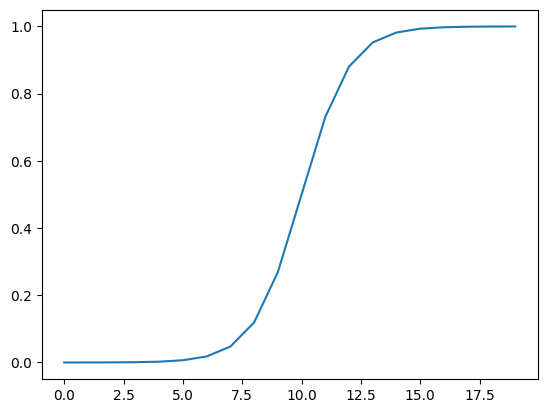

In [58]:
plt.plot(sigmoid(A));

### 8. Putting it all together with a multi-class classification problem
* Binary classification -  one thing or another (cat vs dog, spam vs not spam, fraud or not fraud)
* Multi-class classification = more than one thing or another (cat vs dog vs chicken)

### 8.1 Creating a toy multi-class dataset

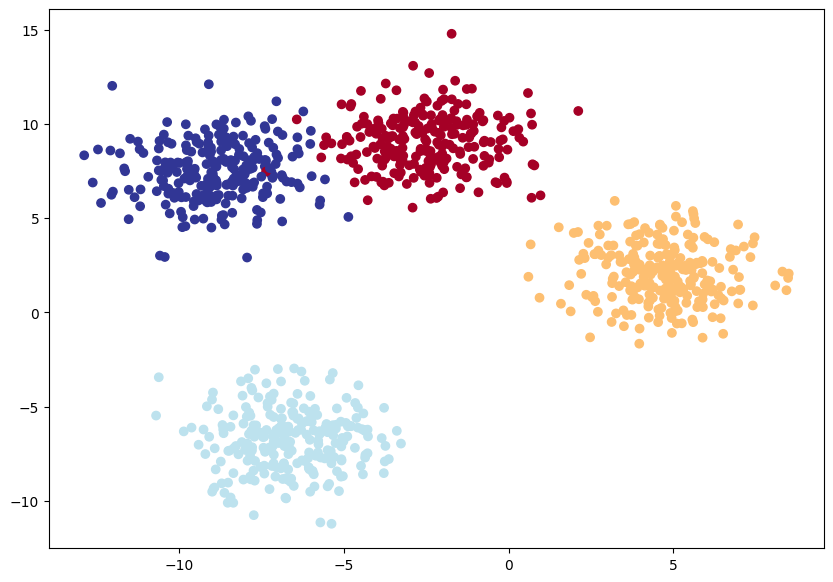

In [59]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,  #give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split data into training and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                      y_blob,
                                                                      test_size=0.2,
                                                                      random_state=RANDOM_SEED)

# 4. Plot the data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 8.3 Building a multi-class classification model in PyTorch

In [60]:
# Create device agnostic code
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [61]:
# Build a multi-class classification model
import torch
from torch import nn
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units):
    """ Initializes multi-class classification model architecture

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of output features of the model
      hidden_units (int): Number of hidden units between layers in model
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

  # Create an instance of BlobModel and send it to target device
model_4 = BlobModel(input_features=2,
                      output_features=4,
                      hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create loss function and an optimizer for a multi-class classification model

In [62]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probabilites for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilites and then to prediction labels

Logits -> Pred probs -> Pred labels

In [63]:
# Let's get some raw output of our model(logits)
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))
y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [64]:
# Convert our model's logit outputs to prediciton probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [65]:
y_pred_probs[0]

tensor([0.3169, 0.3244, 0.1405, 0.2182], device='cuda:0')

In [66]:
torch.argmax(y_pred_probs[0])

tensor(1, device='cuda:0')

In [67]:
# Convert our model's prediction probabilites to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [68]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [69]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data on the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Training loop
for epoch in range(epochs):
  ### Training
  model_4.train()

  # 1. Forward pass
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
# Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_pred)
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.66069, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24508, Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test Loss: 0.10229, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test Loss: 0.05848, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test Loss: 0.04293, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test Loss: 0.03491, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.02988, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.02663, Test Acc: 99.50%


### 8.6 Making and evaluating prediction with a PyTorch multi-class model

In [70]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)
  y_pred_prob = torch.softmax(y_logits, dim=1)

In [71]:
y_pred_prob[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]], device='cuda:0')

In [72]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [73]:
y_preds = torch.argmax(y_pred_prob, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

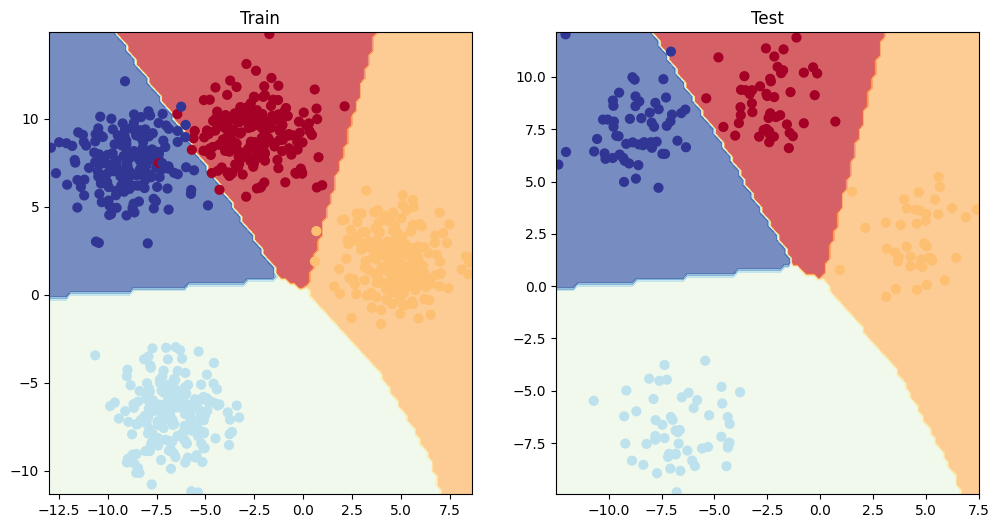

In [74]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_4,X_blob_test,y_blob_test)

## 9. A few more classification metrics..(to evaluate our classification model)
* Accuracy - out of 100 samples, how many model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

see the precision, recall,f1-score - https://medium.com/@nagrajdesaee/beyond-accuracy-deep-dive-into-classification-metrics-confusion-matrix-precision-recall-f1-1428d4e7f1d2

In [75]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 28.2 MB/s eta 0:00:00


In [76]:
from torchmetrics import Accuracy

In [81]:
acc = Accuracy(task="multiclass", num_classes=4).to(device)
acc(y_preds, y_blob_test,)

tensor(0.9950, device='cuda:0')